In [114]:
import os
absolute_path = os.path.abspath("SIFT.ipynb")
print("Full path: " + absolute_path)
print("Directory Path: " + os.path.dirname(absolute_path))

Full path: C:\Users\SashaR\Desktop\IP-HW4\SIFT.ipynb
Directory Path: C:\Users\SashaR\Desktop\IP-HW4


In [140]:
def show_img_jupyter(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

In [115]:
import cv2 
import pickle
import matplotlib.pyplot as plt

In [116]:
def imageResizeTrain(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

def imageResizeTest(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

In [148]:
img = cv2.imread("molly.jpg",cv2.IMREAD_UNCHANGED)

In [151]:
def rotate_img(img, degree):
    (h, w, d) = img.shape # 讀取圖片大小
    center = (w // 2, h // 2) # 找到圖片中心
    
    # 第一個參數旋轉中心，第二個參數旋轉角度(-順時針/+逆時針)，第三個參數縮放比例
    M = cv2.getRotationMatrix2D(center, degree, 1.0)
    
    # 第三個參數變化後的圖片大小
    rotate_img = cv2.warpAffine(img, M, (w, h))
    
    return rotate_img

In [152]:
img15 = rotate_img(img,15)
img30 = rotate_img(img,30)

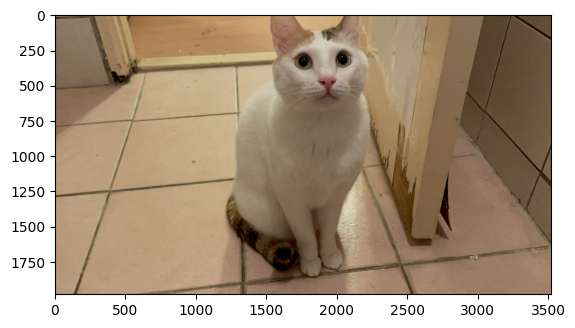

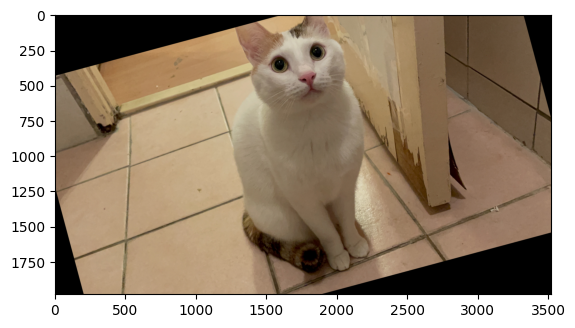

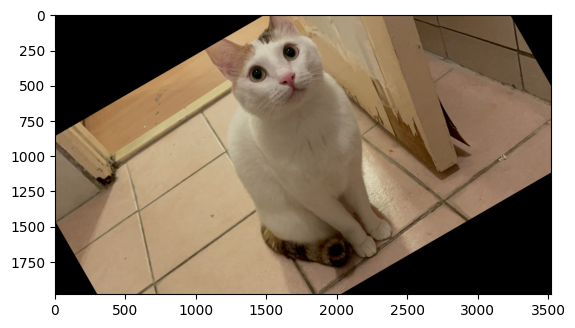

In [283]:
show_img_jupyter(img)
show_img_jupyter(img15)
show_img_jupyter(img30)

In [155]:
cv2.imwrite("molly15.jpg", img15)
cv2.imwrite("molly30.jpg", img30)

True

In [157]:
imageList = ["molly.jpg","molly15.jpg","molly30.jpg"]
imgpath = "C:/Users/SashaR/Desktop/IP-HW4/"

In [158]:
sift = cv2.SIFT_create()

def computeSIFT(image):
    return sift.detectAndCompute(image, None)

In [159]:
cv2.imread("molly.jpg",0)

array([[129, 135, 132, ...,  82,  82,  82],
       [133, 137, 134, ...,  83,  83,  82],
       [135, 136, 133, ...,  83,  83,  82],
       ...,
       [158, 158, 158, ..., 135, 139, 138],
       [158, 158, 158, ..., 135, 137, 134],
       [158, 158, 158, ..., 135, 135, 131]], dtype=uint8)

In [160]:
imagesBW = []
for imageName in imageList:
    imagePath = imgpath + str(imageName)
    imagesBW.append(imageResizeTrain(cv2.imread(imagePath,0))) # flag 0 means grayscale
    #imagesBW.append(cv2.imread(imagePath,0)) # flag 0 means grayscale

In [286]:
keypoints = []
descriptors = []
for i,image in enumerate(imagesBW):
    print("Starting for image: " + imageList[i])
    keypointTemp, descriptorTemp = computeSIFT(image)
    keypoints.append(keypointTemp)
    #descriptors.append(descriptorTemp)
    print("  Ending for image: " + imageList[i])

Starting for image: molly.jpg
  Ending for image: molly.jpg
Starting for image: molly15.jpg
  Ending for image: molly15.jpg
Starting for image: molly30.jpg
  Ending for image: molly30.jpg


In [285]:
print(imageList)
#print(keypoints)
#print(descriptors)

['molly.jpg', 'molly15.jpg', 'molly30.jpg']


In [164]:
for i,descriptor in enumerate(descriptors):
    filepath = imgpath + str(imageList[i].split('.')[0]) + "descriptor.txt"
    with open(filepath, 'wb') as fp:
        pickle.dump(descriptor, fp)

In [163]:
for i,keypoint in enumerate(keypoints):
    deserializedKeypoints = []
    filepath = imgpath + str(imageList[i].split('.')[0]) + "keypoint.txt"
    for point in keypoint:
        temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
        deserializedKeypoints.append(temp)
    with open(filepath, 'wb') as fp:
        pickle.dump(deserializedKeypoints, fp)   

In [165]:
def fetchKeypointFromFile(i):
    filepath = imgpath + str(imageList[i].split('.')[0]) + "keypoint.txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(
            x=point[0][0],
            y=point[0][1],
            size=point[1],
            angle=point[2],
            response=point[3],
            octave=point[4],
            class_id=point[5]
        )
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = imgpath + str(imageList[i].split('.')[0]) + "descriptor.txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

In [166]:
bf = cv2.BFMatcher()
def calculateMatches(des1,des2):
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

In [287]:
def showResult(i):
    keypointi = fetchKeypointFromFile(i)
    imagei = imageResizeTest(cv2.imread(imgpath + imageList[i]))
    imagei = cv2.cvtColor(imagei, cv2.COLOR_BGR2RGB)
    #print(keypointi)
    pointsi = cv2.KeyPoint_convert(keypointi)
    print("Number of feature points: ",len(pointsi))
    #print(type(pointsi[0][0]))
    #print(pointsi)
    pointsi = pointsi.astype(int)
    #print(pointsi)
    for point in pointsi:
        ploti = cv2.circle(imagei,tuple(point), radius=3, color=(255, 0, 255), thickness=-1)
    plt.imshow(ploti),plt.show()
    
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    print("matches: ",len(matches),"\n1st img keypoints: ",len(keypoint1),"\n2nd img keypoints: ",len(keypoint2),"\n1st img descriptors: ",len(descriptor1),"\n2nd img descriptors: ",len(descriptor2))
    print(score)
    plt.imshow(plot),plt.show()
    
def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeTest(cv2.imread(imgpath + imageList[i]))
    image2 = imageResizeTest(cv2.imread(imgpath + imageList[j]))
    #image1 = (cv2.imread(imgpath + imageList[i]))
    #image2 = (cv2.imread(imgpath + imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

In [279]:
def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(
        image1,
        keypoint1,
        image2,
        keypoint2,
        matches,
        None,
        [255,255,255],
        flags=2
    )
    return matchPlot

Number of feature points:  729


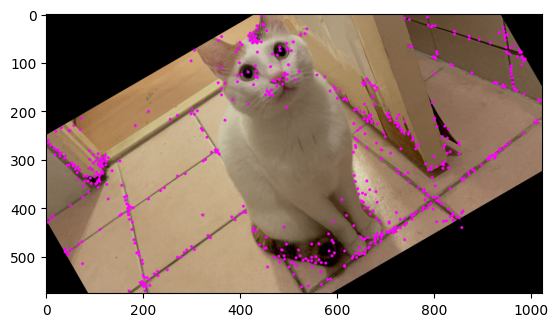

In [290]:
#showResult(0)
#showResult(1)
showResult(2)

matches:  388 
1st img keypoints:  770 
2nd img keypoints:  720 
1st img descriptors:  770 
2nd img descriptors:  720
53.888888888888886


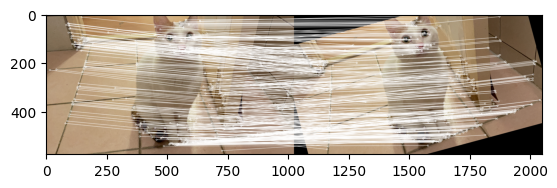

In [194]:
calculateResultsFor(0,1)

In [130]:
image = cv2.circle(image, (x,y), radius=0, color=(0, 0, 255), thickness=-1)

NameError: name 'x' is not defined